In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import glob
import statsmodels.api as sm
import collections
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
from scipy.linalg import toeplitz
from patsy import dmatrices
from math import sqrt
sns.set_style('white')

Pair trading on Commodity in China tested on 2018 and 2019 data

In [2]:
#filename_2019 = glob.glob(f'../data/{year}/*.csv')
#filename_2019.sort()
#filename_2019
df_name = pd.read_csv('../data/README.txt', sep = ' ')
df_name

,code,name
0,agm,沪银主力
1,alm,沪铝主力
2,aum,沪金主力
3,bum,石油沥青
4,cfm,一号棉花
5,cum,沪铜主力
6,ebm,苯乙烯主力
7,egm,乙二醇主力
8,hcm,热轧卷板主力
9,im,铁矿石主力


In [3]:
# Select X and Y for pairs trading
X = 'cum'
Y = 'cus'

In [4]:
df_2018 = pd.read_csv(f'../data/2018/{X}.csv', index_col=0, encoding='gbk')
df_2018.columns = ['code', 'time', 'open', 'high', 'low', f'{X}_close', f'{X}_volume', 'turnover', 'open interest']
df_2018.rename_axis("type", axis='index', inplace=True)

df_2019 = pd.read_csv(f'../data/2019/{X}.csv', index_col=0, encoding='gbk')
df_2019.columns = ['code', 'time', 'open', 'high', 'low', f'{X}_close', f'{X}_volume', 'turnover', 'open interest']
df_2019.rename_axis("type", axis='index', inplace=True)

df = pd.concat([df_2018, df_2019])
df['time'] = pd.to_datetime(df['time'])

df.reset_index(inplace=True)
df_2018

,code,time,open,high,low,cum_close,cum_volume,turnover,open interest
type,,,,,,,,,
SC,cu1802,2018-01-02 09:01:00,55400.0,55550.0,55370.0,55430.0,3140.0,870263700.0,165070
SC,cu1802,2018-01-02 09:02:00,55440.0,55480.0,55390.0,55400.0,1572.0,435747000.0,164880
SC,cu1802,2018-01-02 09:03:00,55400.0,55420.0,55360.0,55380.0,640.0,177243900.0,164798
SC,cu1802,2018-01-02 09:04:00,55380.0,55420.0,55370.0,55370.0,716.0,198312600.0,164722
SC,cu1802,2018-01-02 09:05:00,55370.0,55420.0,55360.0,55420.0,1108.0,306852900.0,164728
...,...,...,...,...,...,...,...,...,...
SC,cu1902,2018-12-28 14:56:00,48310.0,48320.0,48300.0,48310.0,936.0,226085400.0,151434
SC,cu1902,2018-12-28 14:57:00,48310.0,48330.0,48300.0,48320.0,750.0,181175100.0,151390
SC,cu1902,2018-12-28 14:58:00,48320.0,48320.0,48300.0,48300.0,504.0,121736300.0,150994


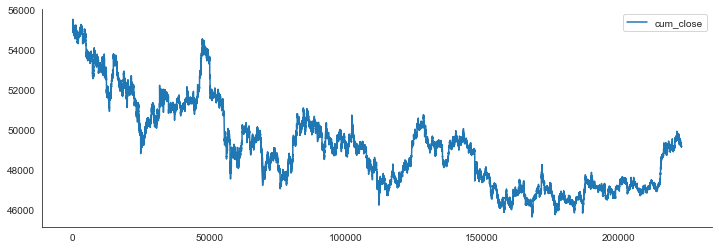

In [5]:
df[[f'{X}_close']].plot(grid=False, figsize=(12,4))
sns.despine()

In [6]:
df_other_2018 = pd.read_csv(f'../data/2018/{Y}.csv', index_col=0, encoding='gbk')
df_other_2018.columns = ['code', 'time', 'open', 'high', 'low', f'{Y}_close', f'{Y}_volume', 'turnover', 'open interest']
df_other_2018.rename_axis("type", axis='index', inplace=True)

df_other_2019 = pd.read_csv(f'../data/2019/{Y}.csv', index_col=0, encoding='gbk')
df_other_2019.columns = ['code', 'time', 'open', 'high', 'low', f'{Y}_close', f'{Y}_volume', 'turnover', 'open interest']
df_other_2019.rename_axis("type", axis='index', inplace=True)

df_other = pd.concat([df_other_2018, df_other_2019])
df_other['time'] = pd.to_datetime(df_other['time'])

df_other.reset_index(inplace=True)

df_other_2018

,code,time,open,high,low,cus_close,cus_volume,turnover,open interest
type,,,,,,,,,
SC,cu1803,2018-01-02 09:01:00,55540.0,55640.0,55500.0,55560.0,3142.0,873017400.0,220126
SC,cu1803,2018-01-02 09:02:00,55570.0,55620.0,55530.0,55540.0,1068.0,296733200.0,220062
SC,cu1803,2018-01-02 09:03:00,55530.0,55550.0,55490.0,55510.0,656.0,182105800.0,220018
SC,cu1803,2018-01-02 09:04:00,55510.0,55540.0,55490.0,55490.0,608.0,168777100.0,219958
SC,cu1803,2018-01-02 09:05:00,55490.0,55540.0,55490.0,55540.0,788.0,218729100.0,220128
...,...,...,...,...,...,...,...,...,...
SC,cu1903,2018-12-28 14:56:00,48290.0,48300.0,48280.0,48290.0,332.0,80159700.0,144318
SC,cu1903,2018-12-28 14:57:00,48290.0,48300.0,48280.0,48290.0,160.0,38632100.0,144354
SC,cu1903,2018-12-28 14:58:00,48290.0,48290.0,48280.0,48280.0,250.0,60355500.0,144312


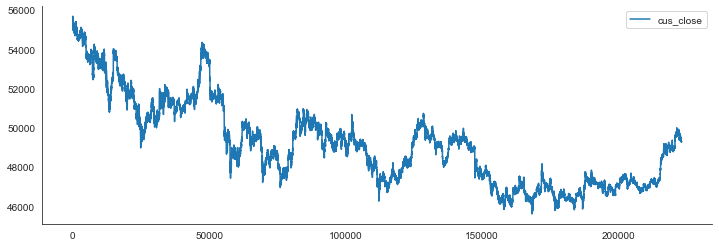

In [7]:
df_other[[f'{Y}_close']].plot(grid=False, figsize=(12,4))
sns.despine()

In [8]:
# df = df[[f'{X}_close', f'{X}_volume']]

irrelevant_col = ['code', 'open', 'high', 'low', 'turnover', 'open interest']
df.drop(columns=irrelevant_col, inplace = True)
    
df[f'{Y}_close'] = df_other.loc[:, f'{Y}_close'].copy()
df[f'{Y}_volume'] = df_other.loc[:, f'{Y}_volume'].copy()
df[f'{Y}_time'] = df_other.loc[:, 'time'].copy()

In [9]:
df[df['time'] != df[f'{Y}_time']]

,type,time,cum_close,cum_volume,cus_close,cus_volume,cus_time


The unit of silver is RMB/kg while the unit of gold is RMB/gram, causing the huge price difference between them

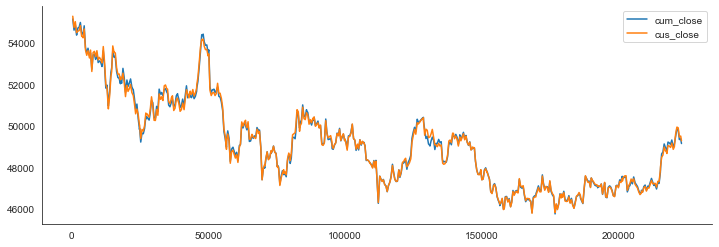

In [10]:
# df_day[f'{Y}_close_adjusted'] = df_day[f'{Y}_close']/10
# adjust the price difference
df['date'] = df['time'].dt.date

df['date_after'] = df['date'].shift(-1)
df["daily_close"] = (df["date_after"] != df["date"])
df_day = df.loc[df["daily_close"] ].copy()
df_day[[f'{X}_close',f'{Y}_close']].plot(grid=False, figsize=(12,4))
sns.despine()
#df_day.set_index('date', inplace=True)
df_day.reset_index(inplace=True)

In [11]:
df_day[df_day['time'] != df_day[f'{Y}_time']]

,index,type,time,cum_close,cum_volume,cus_close,cus_volume,cus_time,date,date_after,daily_close


In [12]:
df_day[f'{X}:log_ret'] = np.log(df_day[f'{X}_close']/df_day[f'{X}_close'].shift(1))
df_day[f'{Y}:log_ret'] = np.log(df_day[f'{Y}_close']/df_day[f'{Y}_close'].shift(1))

In [13]:
df_day

,index,type,time,cum_close,cum_volume,cus_close,cus_volume,cus_time,date,date_after,daily_close,cum:log_ret,cus:log_ret
0,403,SC,2018-01-02 23:59:00,55150.0,4.0,55280.0,32.0,2018-01-02 23:59:00,2018-01-02,2018-01-03,True,NaN,NaN
1,868,SC,2018-01-03 23:59:00,54610.0,30.0,54740.0,68.0,2018-01-03 23:59:00,2018-01-03,2018-01-04,True,-0.009840,-0.009816
2,1333,SC,2018-01-04 23:59:00,54880.0,84.0,55020.0,36.0,2018-01-04 23:59:00,2018-01-04,2018-01-05,True,0.004932,0.005102
3,1798,SC,2018-01-05 23:59:00,54370.0,58.0,54490.0,150.0,2018-01-05 23:59:00,2018-01-05,2018-01-06,True,-0.009336,-0.009680
4,1859,SC,2018-01-06 01:00:00,54390.0,164.0,54530.0,218.0,2018-01-06 01:00:00,2018-01-06,2018-01-08,True,0.000368,0.000734
...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,221878,SC,2019-12-26 23:59:00,49790.0,6.0,49910.0,32.0,2019-12-26 23:59:00,2019-12-26,2019-12-27,True,-0.001405,-0.000601
572,222343,SC,2019-12-27 23:59:00,49340.0,158.0,49460.0,78.0,2019-12-27 23:59:00,2019-12-27,2019-12-28,True,-0.009079,-0.009057
573,222404,SC,2019-12-28 01:00:00,49380.0,642.0,49490.0,100.0,2019-12-28 01:00:00,2019-12-28,2019-12-30,True,0.000810,0.000606
574,222808,SC,2019-12-30 23:59:00,49370.0,142.0,49510.0,182.0,2019-12-30 23:59:00,2019-12-30,2019-12-31,True,-0.000203,0.000404


In [14]:
df_day[f'{X}:Adj_Dollar_Volume'] = df_day[f'{X}_close'] * df_day[f'{X}_volume']
df_day[f'{Y}:Adj_Dollar_Volume'] = df_day[f'{Y}_close'] * df_day[f'{Y}_volume']

aum is less liquid of the two commodity 

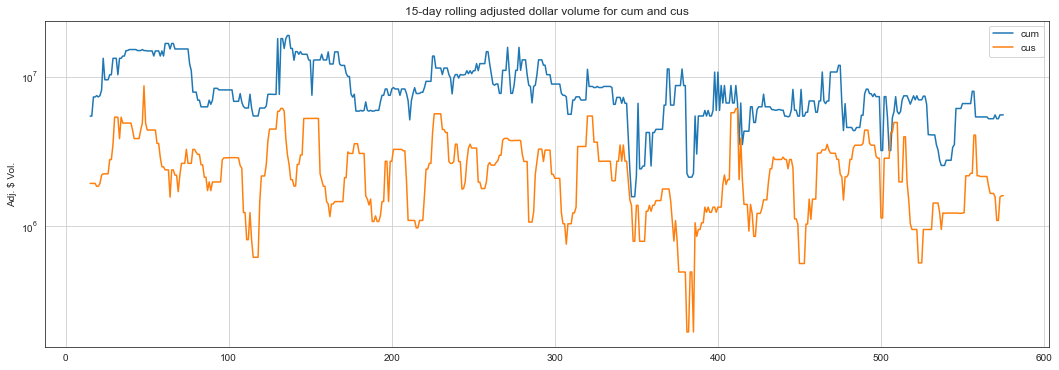

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(18,6))
df_day[f'{X}:Adj_Dollar_Volume'].shift(1).rolling(15).median().plot(grid=True, ax=axs, label=X, logy=True)
df_day[f'{Y}:Adj_Dollar_Volume'].shift(1).rolling(15).median().plot(grid=True, ax=axs, label=Y, logy=True)
axs.set(ylabel='Adj. $ Vol.', title=f'15-day rolling adjusted dollar volume for {X} and {Y}')
axs.legend();

In [16]:
# Nt is supposed to have the rolling median of the dollar volume of the less liquid 
df_day['Nt'] = df_day[f'{Y}:Adj_Dollar_Volume'].shift(1).rolling(15).median() 

In [17]:
df_day['Nt'] = 1000000

In [18]:
def calculate_hull_moving_average(df, period, close):

    df['window_t_ewm'] = df[close].ewm(span=period).mean()
    df['window_half_ewm'] = df[close].ewm(span=period/2).mean()
    df['diff']=df['window_half_ewm'] * 2 - df['window_t_ewm']
    
    df[f'hma{period}_{close}']=df['diff'].ewm(span=int(math.sqrt(period))).mean()
    
    irrelevant_col = ['window_t_ewm', 'window_half_ewm', 'diff']
    df.drop(columns=irrelevant_col, inplace = True)
    

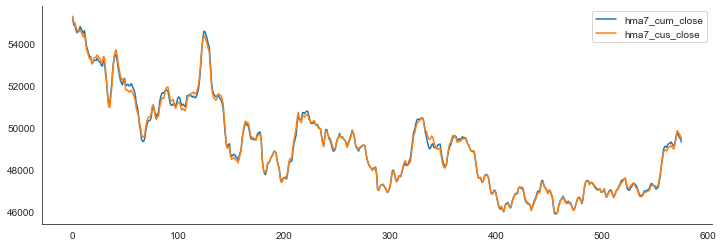

In [19]:
calculate_hull_moving_average(df_day, 7, f'{X}_close')
calculate_hull_moving_average(df_day, 7, f'{Y}_close')
df_day[[f'hma7_{X}_close',f'hma7_{Y}_close']].plot(grid=False, figsize=(12,4))
sns.despine()

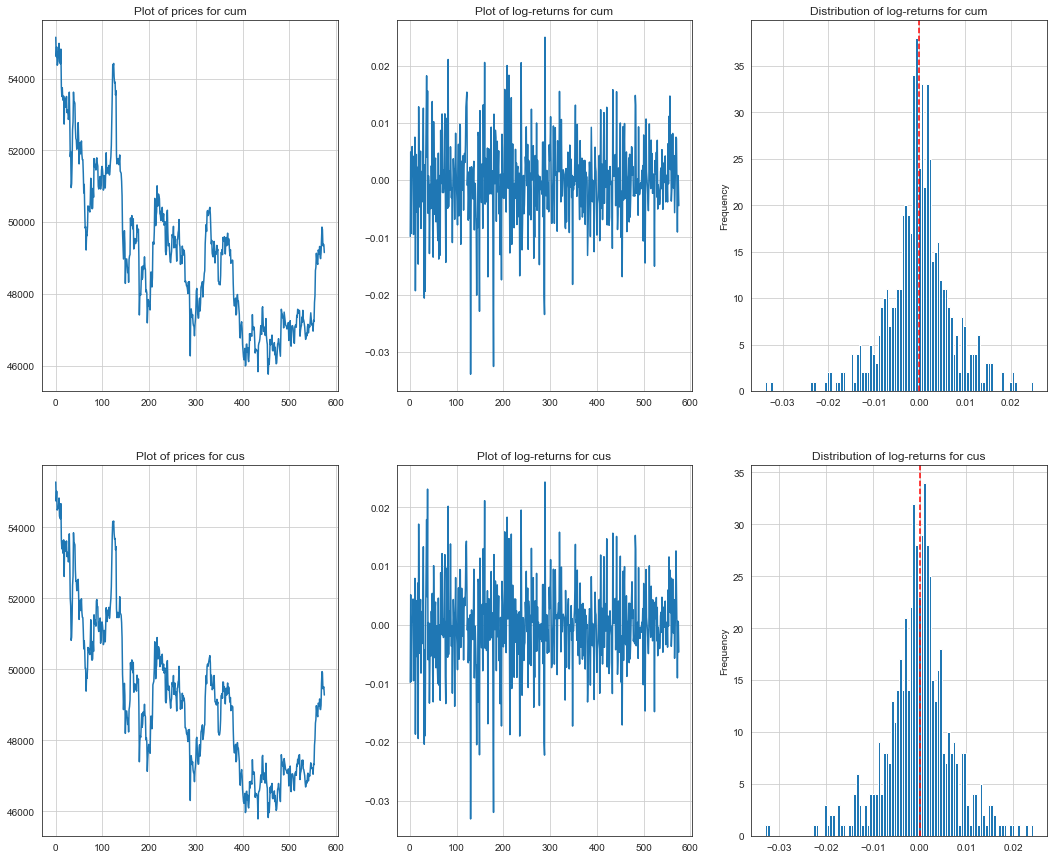

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(18, 15))
df_day[f'{X}_close'].plot(ax=axs[0, 0], title=f'Plot of prices for {X}', grid=True)
df_day[f'{X}:log_ret'].plot(ax=axs[0, 1], title=f'Plot of log-returns for {X}', grid=True)
df_day[f'{X}:log_ret'].plot(kind='hist', bins=100, ax=axs[0, 2], title=f'Distribution of log-returns for {X}', grid=True)
axs[0, 2].axvline(df_day[f'{X}:log_ret'].median(), color='red', linestyle='--')

df_day[f'{Y}_close'].plot( ax=axs[1, 0], title=f'Plot of prices for {Y}', grid=True)
df_day[f'{Y}:log_ret'].plot(ax=axs[1, 1], grid=True, title=f'Plot of log-returns for {Y}',)
df_day[f'{Y}:log_ret'].plot(kind='hist', bins=100, ax=axs[1, 2], grid=True, title=f'Distribution of log-returns for {Y}',);
axs[1, 2].axvline(df_day[f'{Y}:log_ret'].median(), color='red', linestyle='--');

In [21]:
long_leg = f'{X}:log_ret'
short_leg = f'{Y}:log_ret'
df_spreads = pd.DataFrame()

for rolling_period in range(1, 51):
    df_spreads[rolling_period] = df_day[long_leg].rolling(rolling_period).sum() - df_day[short_leg].rolling(rolling_period).sum()

In [22]:
df_spread_stats = df_spreads.describe([x/10 for x in range(1,10)] + [0.005, 0.995])

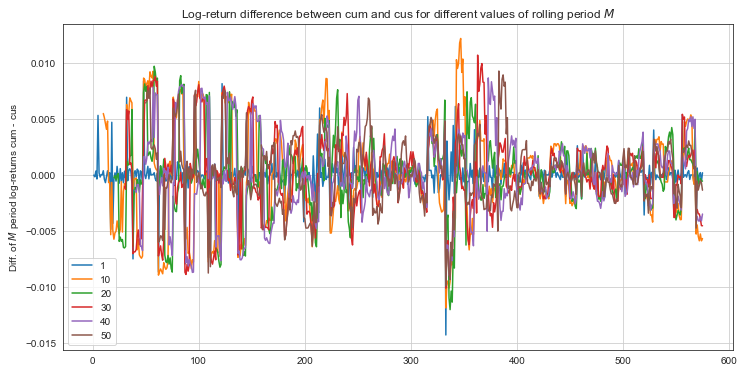

In [23]:
df_spreads[[1, 10, 20, 30, 40, 50]].plot(figsize=(12, 6), grid=True, 
                                         ylabel=f'Diff. of $M$ period log-returns {X} - {Y}',
                                         title=f'Log-return difference between {X} and {Y} for different values of rolling period $M$');

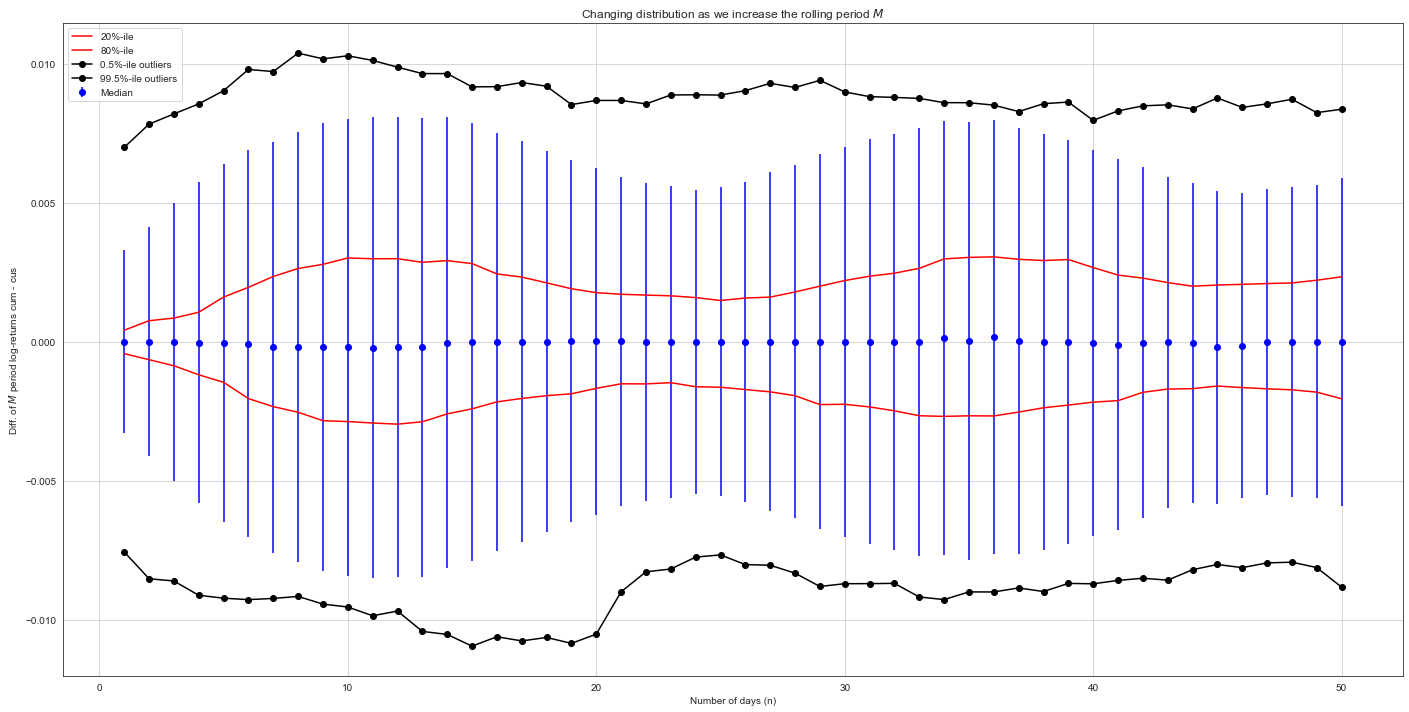

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(24, 12))
ax.errorbar(df_spread_stats.T['50%'].index, df_spread_stats.T['50%'], yerr=2*df_spread_stats.T['std'], fmt='o', color='blue', 
            label='Median'
            );


# 20 and 80 pctiles
ax.plot(df_spread_stats.T['20%'].index, df_spread_stats.T['20%'], color='red', label='20%-ile');
ax.plot(df_spread_stats.T['80%'].index, df_spread_stats.T['80%'], color='red', label='80%-ile');

# using 0.5 and 99.5 pctiles as outliers
ax.plot(df_spread_stats.T['0.5%'].index, df_spread_stats.T['0.5%'], color='black', marker='o', label='0.5%-ile outliers');
ax.plot(df_spread_stats.T['99.5%'].index, df_spread_stats.T['99.5%'], color='black', marker='o', label='99.5%-ile outliers');


ax.set(xlabel='Number of days (n)',
       ylabel=f'Diff. of $M$ period log-returns {X} - {Y}',
       title='Changing distribution as we increase the rolling period $M$');
ax.grid(True)
ax.legend();

In [25]:
# we want to find first and last trading day of the month
# Don't restrict to day = 1 or day = 30/31 on account of holidays
df_day['dtformat'] = df_day.time.dt.strftime('%Y%m')
df_day['dt'] = df_day.index
df_day['last_trading_day_month'] = df_day.index == df_day.dtformat.map(df_day.groupby(['dtformat'])['dt'].max().to_dict())
df_day['first_trading_day_month'] = df_day.index == df_day.dtformat.map(df_day.groupby(['dtformat'])['dt'].min().to_dict())
del df_day['dtformat']
del df_day['dt']

In [26]:
def produce_trading_strategy(df, long_leg, short_leg, M, j, g, exit_stop_loss):
    """
    Simulate the strategy for a given spread. 
    long_leg corresponds to the long leg of the spread.
    M corresponds to the period for rolling returns
    j is the lower bound and g is the upper bound
    exit_stop_loss is position_value / gross_traded_cash ratio
    below which we will exit our position
    Returns a dataframe with our capital stock worth at each point of time
    """
    df_strat = df.copy()
    
    # first find the s based on the rolling period M specified. 
    df_strat['s'] = df_strat[long_leg + ':log_ret'].rolling(M).sum() - df_strat[short_leg + ':log_ret'].rolling(M).sum() 
    df_strat['curr_pos'] = None
    df_strat['entry_point'] = False
    df_strat['exit_point'] = False
    df_strat['capital'] = 0 

    curr_pos = None
    curr_num_short_leg = 0
    curr_num_long_leg = 0
    entry_price_short_leg = 0
    entry_price_long_leg = 0 
    gross_traded_cash = 0
    position_value = 0
    capital = df.Nt.max() * 2 # specified in section 3.5 of the homework

    df_strat[long_leg + ':num_shares'] = 0
    df_strat[long_leg + ':entry_price'] = 0
    
    df_strat[short_leg + ':num_shares'] = 0
    df_strat[short_leg + ':entry_price'] = 0
    
    df_strat['position_value'] = 0 # this is reset upon every entry/exit transaction. Thus, it is unique to each position
    
    for idx, row in df_strat.iterrows():
        
        nt = row.Nt # we want our short/long cash position to be 100% of Nt
        
        # if the spread value has cross our set upper bound then go short on the spread, i.e. short the long leg and long the short leg
        # of the spread
        if row.s >= g and pd.notnull(nt):            
            # if it is not short already then enter the short position
            if curr_pos != 'short':
                curr_pos = 'short'
                # you need the entry price into the position to mark to market
                entry_price_short_leg = row[short_leg +'_close']
                entry_price_long_leg = row[long_leg +'_close']
                curr_num_short_leg = int( nt / entry_price_short_leg)
                curr_num_long_leg = int( -1*nt / entry_price_long_leg)
                gross_traded_cash = abs(entry_price_short_leg * curr_num_short_leg) + abs(entry_price_long_leg * curr_num_long_leg)
                df_strat.loc[idx, 'entry_point'] = True
                
        # if the spread value has crossed our set lower bound then go long on the spread
        elif row.s <= j and pd.notnull(nt):
            # if it is not long already then enter the long position
            if curr_pos != 'long':
                curr_pos = 'long'
                entry_price_short_leg = row[short_leg +'_close']
                entry_price_long_leg = row[long_leg +'_close']
                curr_num_short_leg = int( -1*nt / entry_price_short_leg)
                curr_num_long_leg = int( nt / entry_price_long_leg)
                gross_traded_cash = abs(entry_price_short_leg * curr_num_short_leg) + abs(entry_price_long_leg * curr_num_long_leg)
                df_strat.loc[idx, 'entry_point'] = True
                
        df_strat.loc[idx, 'curr_pos'] = curr_pos
        df_strat.loc[idx, long_leg + ':num_shares'] = curr_num_long_leg
        df_strat.loc[idx, short_leg + ':num_shares'] = curr_num_short_leg
        df_strat.loc[idx, long_leg + ':entry_price'] = entry_price_long_leg
        df_strat.loc[idx, short_leg + ':entry_price'] = entry_price_short_leg
        df_strat.loc[idx, 'gross_traded_cash'] = gross_traded_cash
        
        today_position_value = curr_num_long_leg * (row[long_leg + '_close'] - entry_price_long_leg) 
        today_position_value += curr_num_short_leg * (row[short_leg + '_close'] - entry_price_short_leg)
        change_in_pos_val = today_position_value - position_value # this will be added to capital
        position_value = today_position_value
        df_strat.loc[idx, 'position_value'] = position_value 
        
        capital += change_in_pos_val
        df_strat.loc[idx, 'capital'] = capital
        
        if (position_value != 0 and gross_traded_cash != 0 and position_value / gross_traded_cash <= exit_stop_loss):
            # close position
            df_strat.loc[idx, 'exit_point'] = True
            
        if curr_pos is not None:
            # if you have an ongoing position and it's the last trading day of the month - exit
            if curr_pos == 'short' and row.s < g/2: # stop our short position
                df_strat.loc[idx, 'exit_point'] = True
            elif curr_pos == 'long' and row.s > j/2: # stop our long position
                df_strat.loc[idx, 'exit_point'] = True
            
        if df_strat.loc[idx, 'exit_point']:
            curr_pos = None
            entry_price_short_leg = 0
            entry_price_long_leg = 0
            curr_num_short_leg = 0
            curr_num_long_leg = 0
            gross_traded_cash = 0
            position_value = 0 # reset position value
        
    if df_strat.loc[idx, 'curr_pos'] is not None: # Exit on last day
        df_strat.loc[idx, 'exit_point'] = True
        df_strat.loc[idx, 'curr_pos'] = None
            
    return df_strat

In [27]:
# Running a grid search on our entry exit points, rolling period as well as stop loss
ls_grid_cells = []
strat_grid_record = collections.namedtuple('Record', 'M j g s end_capital')
for M in [10, 20, 30, 40, 50]:
    sigma = df_spread_stats[M]['std']
    mu = df_spread_stats[M]['mean']
    for sigma_mult in [1, 2, 3]:
        for s in np.linspace(0, -0.05, 5):
                j = mu - sigma_mult*sigma
                g = mu + sigma_mult*sigma
                df_strat_for_grid_cell = produce_trading_strategy(df_day, 
                             X, 
                             Y, 
                             M, j, g,
                            exit_stop_loss = s,
                            )
                final_capital = df_strat_for_grid_cell.tail(1).capital.values[0]
                cell_to_add = strat_grid_record(M=M, j=j, g=g, s=s, end_capital=final_capital)
                ls_grid_cells.append(cell_to_add)

In [28]:
df_grid = pd.DataFrame(ls_grid_cells)

In [29]:
df_grid

,M,j,g,s,end_capital
0,10,-0.004129,0.004094,0.0000,2041690
1,10,-0.004129,0.004094,-0.0125,2051880
2,10,-0.004129,0.004094,-0.0250,2051880
3,10,-0.004129,0.004094,-0.0375,2051880
4,10,-0.004129,0.004094,-0.0500,2051880
...,...,...,...,...,...
70,50,-0.008741,0.008964,0.0000,2012440
71,50,-0.008741,0.008964,-0.0125,2012440
72,50,-0.008741,0.008964,-0.0250,2012440
73,50,-0.008741,0.008964,-0.0375,2012440


In [30]:
df_grid['sigma'] = df_grid.M.apply(lambda x: df_spread_stats[x]['std'])
df_grid['spread_width'] = (df_grid['g'] - df_grid['j'])/(2*df_grid['sigma'])
df_grid['spread_width'] = df_grid['spread_width'].apply(round)
df_grid['s'] = df_grid['s'].apply(lambda x: round(x, 3))

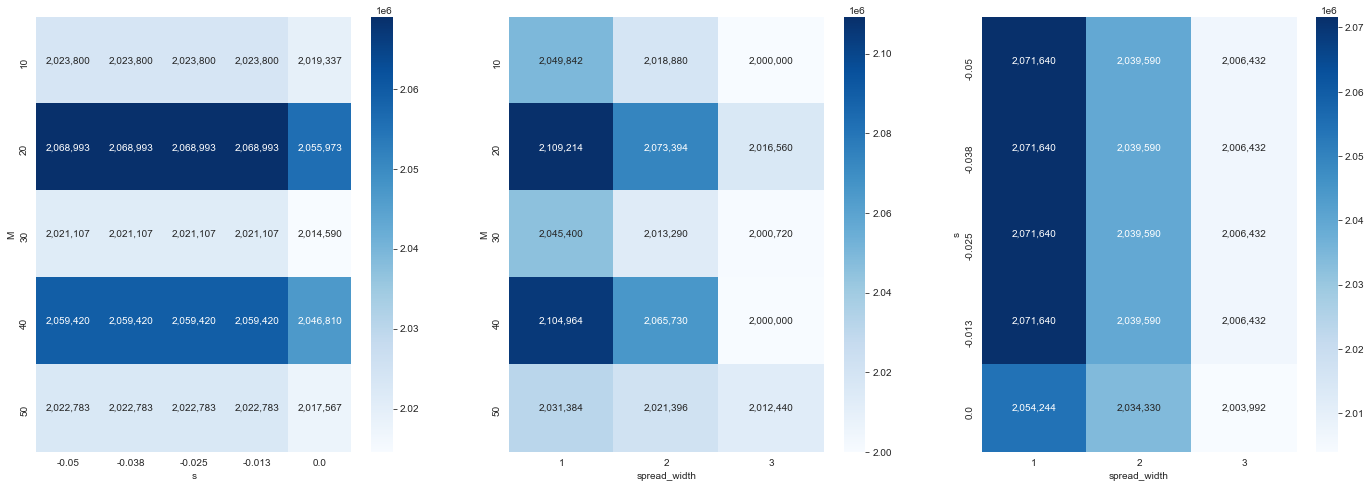

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))
sns.heatmap(pd.pivot_table(df_grid, index='M', columns='s', values='end_capital'), fmt=',.0f', annot=True, cmap='Blues', ax=axs[0])
sns.heatmap(pd.pivot_table(df_grid, index='M', columns='spread_width', values='end_capital'), fmt=',.0f', annot=True, cmap='Blues', ax=axs[1]);
sns.heatmap(pd.pivot_table(df_grid, index='s', columns='spread_width', values='end_capital'), fmt=',.0f', annot=True, cmap='Blues', ax=axs[2]);

In [32]:
M = 30
j = df_spread_stats[M]['mean'] - 2*df_spread_stats[M]['std']
g = df_spread_stats[M]['mean'] + 2*df_spread_stats[M]['std']
df_optimal = produce_trading_strategy(df_day, 
                         X, 
                         Y, 
                         M, j, g,
                        exit_stop_loss = -0.5,
                        )

In [33]:
df_optimal['Strategy Log Returns'] = np.log(df_optimal['capital']/df_optimal['capital'].shift(1)) 

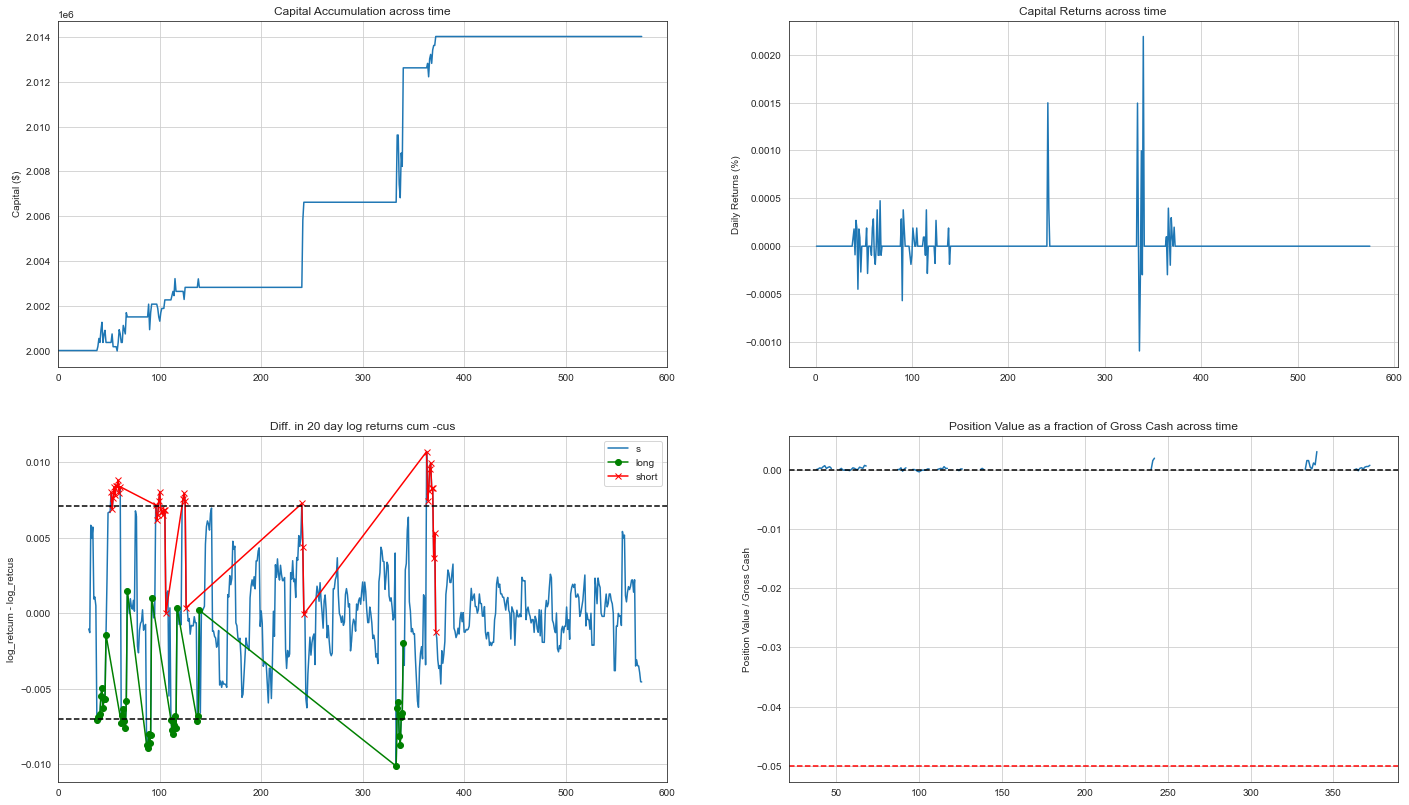

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(24, 14), sharex=False)
df_optimal.capital.plot(ax=axs[0, 0], grid=True, ylabel='Capital ($)', xlim = (0, 600), title='Capital Accumulation across time');
df_optimal.capital.pct_change().plot(ax=axs[0, 1], grid=True, ylabel='Daily Returns (%)', title='Capital Returns across time');


df_optimal['s'].plot(ax=axs[1, 0], label='s', xlim = (0, 600))
df_optimal[df_optimal.curr_pos == 'long']['s'].plot(marker='o', ax=axs[1, 0], color='green', label='long')
df_optimal[df_optimal.curr_pos == 'short']['s'].plot(marker='x', ax=axs[1, 0], color='red', label='short')
axs[1, 0].axhline(g, linestyle='--', color='black')
axs[1, 0].axhline(j, linestyle='--', color='black')
axs[1, 0].grid(True);
axs[1, 0].legend();
axs[1, 0].set(ylabel=f'log_ret{X} - log_ret{Y}', title=f'Diff. in 20 day log returns {X} -{Y}');

(df_optimal.position_value / df_optimal.gross_traded_cash).plot(ax=axs[1, 1], grid=True, 
                                                                title='Position Value as a fraction of Gross Cash across time',
                                                                ylabel='Position Value / Gross Cash');
axs[1, 1].axhline(s, linestyle='--', color='red');
axs[1, 1].axhline(0, linestyle='--', color='black');

In [35]:
##### HELPER FUNCTIONS #####

def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4


def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

                         
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol


import scipy.stats
def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level


def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})


def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r.dropna(), level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=252)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=252)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=252)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

In [36]:
summary_stats(df_optimal[['Strategy Log Returns']])

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Strategy Log Returns,0.003058,0.002519,7.171019,96.195929,-0.000526,0.00001,-10.364596,-0.001394


In [37]:
print('Return on Capital = {:.3f}%'.format((df_optimal['capital'][df_optimal.shape[0]-1]/df_optimal['capital'][0] - 1) * 100))

Return on Capital = 0.701%


In [38]:
df_optimal

,index,type,time,cum_close,cum_volume,cus_close,cus_volume,cus_time,date,date_after,...,entry_point,exit_point,capital,cum:num_shares,cum:entry_price,cus:num_shares,cus:entry_price,position_value,gross_traded_cash,Strategy Log Returns
0,403,SC,2018-01-02 23:59:00,55150.0,4.0,55280.0,32.0,2018-01-02 23:59:00,2018-01-02,2018-01-03,...,False,False,2000000,0,0,0,0,0,0.0,NaN
1,868,SC,2018-01-03 23:59:00,54610.0,30.0,54740.0,68.0,2018-01-03 23:59:00,2018-01-03,2018-01-04,...,False,False,2000000,0,0,0,0,0,0.0,0.0
2,1333,SC,2018-01-04 23:59:00,54880.0,84.0,55020.0,36.0,2018-01-04 23:59:00,2018-01-04,2018-01-05,...,False,False,2000000,0,0,0,0,0,0.0,0.0
3,1798,SC,2018-01-05 23:59:00,54370.0,58.0,54490.0,150.0,2018-01-05 23:59:00,2018-01-05,2018-01-06,...,False,False,2000000,0,0,0,0,0,0.0,0.0
4,1859,SC,2018-01-06 01:00:00,54390.0,164.0,54530.0,218.0,2018-01-06 01:00:00,2018-01-06,2018-01-08,...,False,False,2000000,0,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,221878,SC,2019-12-26 23:59:00,49790.0,6.0,49910.0,32.0,2019-12-26 23:59:00,2019-12-26,2019-12-27,...,False,False,2014020,0,0,0,0,0,0.0,0.0
572,222343,SC,2019-12-27 23:59:00,49340.0,158.0,49460.0,78.0,2019-12-27 23:59:00,2019-12-27,2019-12-28,...,False,False,2014020,0,0,0,0,0,0.0,0.0
573,222404,SC,2019-12-28 01:00:00,49380.0,642.0,49490.0,100.0,2019-12-28 01:00:00,2019-12-28,2019-12-30,...,False,False,2014020,0,0,0,0,0,0.0,0.0
574,222808,SC,2019-12-30 23:59:00,49370.0,142.0,49510.0,182.0,2019-12-30 23:59:00,2019-12-30,2019-12-31,...,False,False,2014020,0,0,0,0,0,0.0,0.0
